# Cvičení 10 - shlukování

V dnešním cvičení budeme zkoumat metody pro shlukování, konkrétně aglomerativní hierarchické shlukován, KMeans a DBSCAN.

Shlukování je jednou z úloh nesupervizovaného učení, kdy nemáme k dispozici žádnou vysvětlovanou proměnnou, kterou bychom chtěli predikovat.

Cílem je tedy se v datech **"vyznat"** - tj. v zásadě zjistit, kde v příznakovém prostoru jsou oblasti s vysokou hustotou dat a kde oblasti s nízkou (nulovou) hustotou.
Metody shlukování se k tomuto přiblíží tím, že rozdělí dataset na shluky bodů, které se vyskytují "blízko" sebe.
Tím vlastně identifikují oblasti, kde se data vyskytují častěji.

Výsledkem shlukování je rozklad množiny dat na jednotlivé shluky. To jest vytvoření $C = (C_1, \dotsc, C_k)$, kde $C_i \subset \mathcal D$ pro každé $i$ a
$C_i \cap C_j = \emptyset$ pro každé $i \neq j$, přičemž
$$
  \mathcal D = \bigcup_{i=1}^k C_i.
$$
Bod $x \in \mathcal D$ je tedy v $i$-tém shluku, jestliže $x \in C_i$.

V tomto notebooku si budeme hrát se shlukováním.
 * Nejprve si na umělých datech vyzkoušíme hierarchické shlukování a algoritmus k-means, abychom si obě metody osahali.
 * Potom provedeme hierarchické shlukování na datasetu Iris (3 druhy kosatců) a podíváme se jak nalezené shluky odpovídají reálným druhům.
 * Nakonec se podíváme na vektorovou kvantizaci obrázků jakožto zajímavou aplikaci algoritmu k-means.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# potlačení výpisu floatů (tak aby 0.000 bylo zobrazeno jako 0.)
np.set_printoptions(precision=5, suppress=True)

### Generování umělých dat

array([[ 5.81716,  9.07905],
       [ 4.41209,  6.52132],
       [ 5.62233,  9.73614],
       ...,
       [24.03556,  9.61117],
       [23.52916,  8.31999],
       [21.72644,  3.82955]])

(1400, 2)


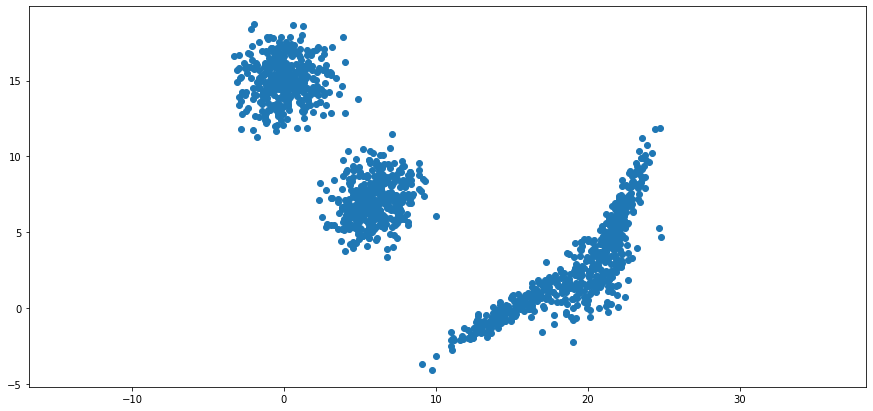

In [38]:
# generování tří shluků: a se 60 body, b se 40 body, c s 60:
np.random.seed(47)  # zajistí replikovatelnost
a = np.random.multivariate_normal([6, 7], [[2, 0.5], [0.5, 2]], size=[400,])
b = np.random.multivariate_normal([0, 15], [[2, 0], [0, 2]], size=[400,])
c1 = np.random.multivariate_normal([15, 0], [[5, 3], [3, 2]], size=[200,])
c2 = np.random.multivariate_normal([20, 2], [[2, 1], [1, 2]], size=[200,])
c3 = np.random.multivariate_normal([22, 6], [[1, 2], [2, 5]], size=[200,])

# spojení shluků do X
X = np.concatenate((a, b, c1, c2, c3),)

display(X)
# zobrazení velikosti výsledných dat
print(X.shape)

# zobrazení výsledných dat
plt.figure(figsize=(15, 7))
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

## Aglomerativní herarchické shlukování

Nejprve použijeme knihovnu `scipy`, konkrétně balíček hierarchického shlukování `scipy.cluster.hierarchy`. [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

### Matice propojení

Pro její sestavení použijeme funkci `linkage`. [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

* Základním  argumentem je (vzdálenost) metrika, která se má použít pro dvojice bodů. [(seznam možností zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
    - výchozí je euklidovská vzdálenost (`euclidean`)
    - k dispozici jsou ale i všechny další "běžné" vzdálenosti, jako např. manhattanská vzdálenost (`cityblock`)

* Dalším klíčovým argumentem je volba metody, kterou se měří vzdálenosti shluků.
* Nyní použijeme metodu nejbližšího souseda - **single linkage** (`single`). Později si můžete zkusit i ostatní:
    - complete linkage (`complete`),
    - average linkage (`average`),
    - wardova metoda (`ward`).
    


In [34]:
from scipy.cluster.hierarchy import linkage

# spočteme tzv. matici propojení
Z = linkage(X, method="single", metric="euclidean")

# rozměry výstupu
print(Z.shape)

(1399, 4)


Výstupem je matice propojení (linkage matrix), ve které každý řádek odpovídá jednomu spojení shluků do nového shluku. 

Sloupce jsou:
* index prvního spojovaného shluku,
* index druhého spojovaného shluku,
* vzdálenost mezi spojovanými shluky,
* počet bodů, které jsou v nově vytvořeném shluku.

In [35]:
# Podívejme se na prvních 5 řádků Z
print(Z[:5,:])

[[347.      378.        0.00336   2.     ]
 [489.      671.        0.00512   2.     ]
 [295.      309.        0.00842   2.     ]
 [455.      664.        0.00897   2.     ]
 [ 71.      238.        0.00983   2.     ]]


Obvzláště si všimněte pátého řádku, kde má jeden ze spojovaných shluků index 143, což je ve skutečnosti třetí  shluk vytvořený spojením bodů s indexy 128 a 138.

### Vizualizace plného dendrogramu

Použijeme funkci `dendrogram` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram).

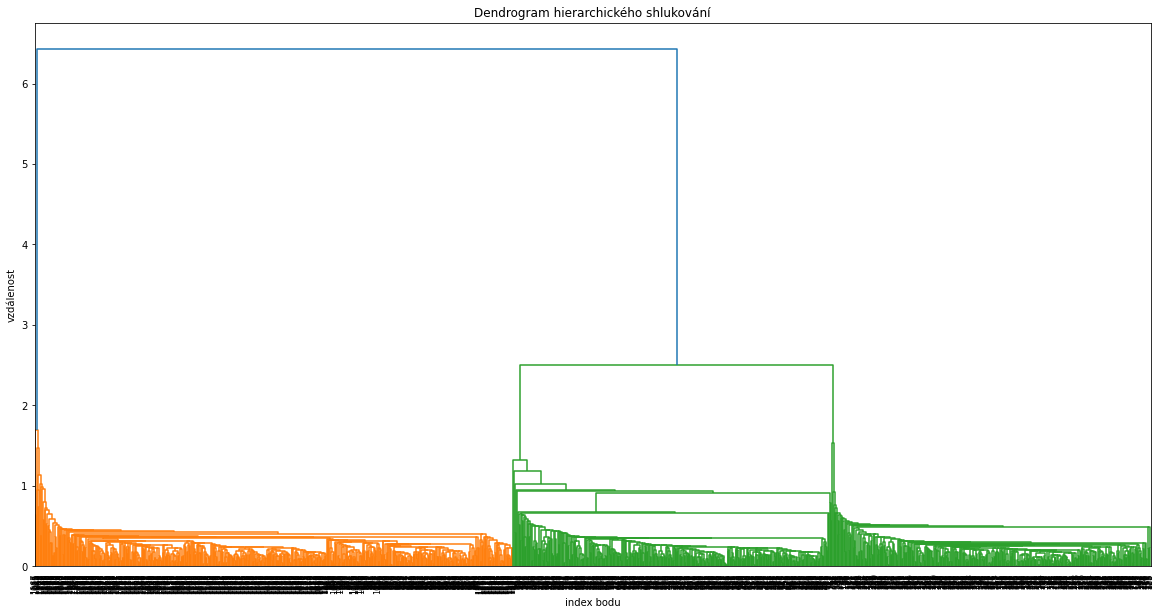

In [36]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(20, 10))
plt.title("Dendrogram hierarchického shlukování")
plt.xlabel("index bodu")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    leaf_rotation=90.,  # otočení popisů x-ové osy
    leaf_font_size=8.,  # velikost fontu popisů x-ové osy
)

plt.show()

Všimněte si, že:
* horizontální čáry odpovídají spojením shluků
* vertikální čáry nám říkají, které shluky se do nového shluku spojují
* výšky (tj. y-ové pozice) horizontálních čar odpovídají vzdálenosti mezi spojovanými shluky

### Vizualizace ořezaného dendrogramu

Zobrazíme pouze horní část dendrogramu, kde dochází ke spojování posledních velkých shluků.

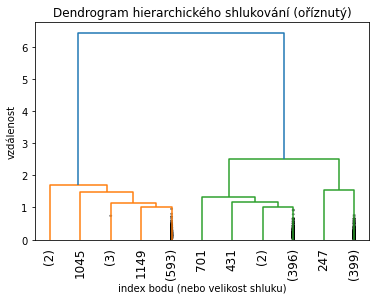

In [37]:
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",  # Zobraz jenom posledních p spojených shluků
    p=11,  # Nastavení tohto p
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # pomáhá vizuální představě o spojování vedoucí k těm uříznutým shlukům 
    # (čárky na spodních vertikálních čárách).
)

plt.show()

### Vizualizace ořezaného dendrogramu s výpisem vzdáleností

S využitím: [annotating the distances inside the dendrogram](https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib/12311618#12311618)

In [7]:
def draw_distance_annotated_dendrogram(*args, **kwargs):
    # pop arguments which are not expected by dendrogram function
    max_d = kwargs.pop("max_d", None)
    annotate_if_above = kwargs.pop("annotate_if_above", 0.0)
    
    if max_d and "color_threshold" not in kwargs:
        kwargs["color_threshold"] = max_d
    
    plt.title("Dendrogram hierarchického shlukování (oříznutý) se vzdáleností")
    plt.xlabel("index bodu (nebo velikost shluku)")
    plt.ylabel("vzdálenost")
    
    # create the dendrogram
    ddata = dendrogram(*args, **kwargs)

    for i, d, c in zip(ddata["icoord"], ddata["dcoord"], ddata["color_list"]):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        # if the annotation value is above the threshold
        if y > annotate_if_above:
            # plot a point at given x, y position
            plt.plot(x, y, "o", c=c)
            # show an annotation by the plotted point
            plt.annotate(
                "%.3g" % y, (x, y), xytext=(0, -5), textcoords="offset points", va="top", ha="center"
            )
    
    # show a horizontal line
    if max_d:
        plt.axhline(y=max_d, c="k")

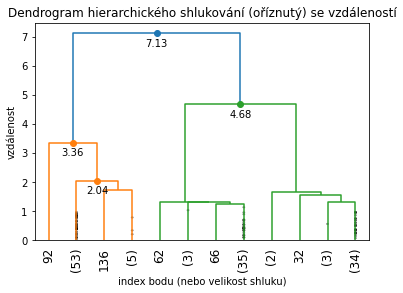

In [8]:
draw_distance_annotated_dendrogram(
    Z,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)

plt.show()

## Získání shlukování z matice propojení

Doposud jsme pouze měli matici propojení a z ní uměli vykreslit dendrogram. Nyní si ukážeme, jak pomocí zvoleného kritéria získáme výsledné shlukování.

Ve všech případech použijeme funkci `fcluster` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster).

### Víme požadovaný počet shluků $k$
To bývá jeden z nejčastějších hyperparametrů shlukovacích algoritmů.

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


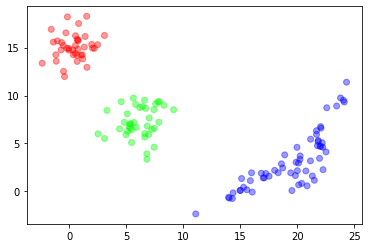

In [9]:
from scipy.cluster.hierarchy import fcluster

k = 3

k_clusters = fcluster(Z, k, criterion="maxclust")

# výpis shlukování
print(k_clusters)

plt.scatter(X[:,0], X[:,1], c=k_clusters, cmap="brg", alpha=0.4)
plt.show()

### Víme požadovanou maximální vzdálenost nad kterou již nechceme shluky spojovat

Máme tedy výšku řezu v dendrogramu. 

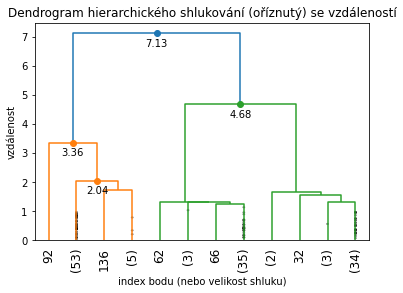

In [10]:
draw_distance_annotated_dendrogram(
    Z,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)

plt.show()

Vybereme si vhodnou výšku a provedeme řez.

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


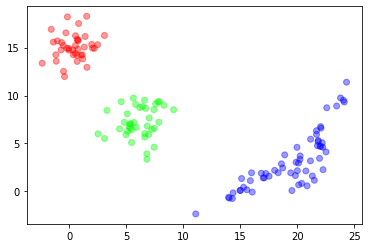

In [11]:
max_d = 4

clusters = fcluster(Z, max_d, criterion="distance")

print(clusters)  # výpis shlukování

plt.scatter(X[:,0], X[:,1], c=clusters, cmap="brg", alpha=0.4)  # plot points with cluster dependent colors
plt.show()

### Využití `sklearn`

Hierarchické aglomerativní shlukování je také implementováno v knihovn `sklearn`
jako `sklearn.cluster.AgglomerativeClustering`.

Zde již není výstupem matice propojení, ale výsledné shlukování (matici propojení ale lze také získat).
Hodí se tedy především, když například známe požadovaný výsledný počet shluků, nebo hranici vzdálenosti, nad kterou už shluky spojovat nechceme.

In [12]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage = 'single', compute_distances = True)
agg.fit(X)

AgglomerativeClustering(compute_distances=True, distance_threshold=4,
                        linkage='single', n_clusters=None)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


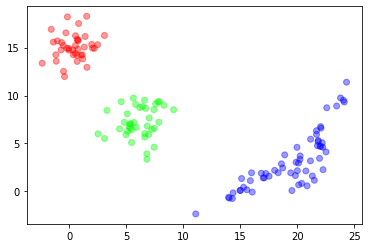

In [13]:
print(agg.labels_)  # výpis shlukování

plt.scatter(X[:,0], X[:,1], c=agg.labels_, cmap="brg", alpha=0.4)  # plot points with cluster dependent colors
plt.show()

Pokud bychom chtěli v tomto případě nakreslit dendrogram, musíme si nejprve sestrojit matici propojení.

In [14]:
def get_linkage_matrix(model):
    """
    Konstrukce matice propojení z objektu AgglomerativeClustering
    """
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
            [agg.children_, agg.distances_, counts]
        ).astype(float)
    
    return linkage_matrix

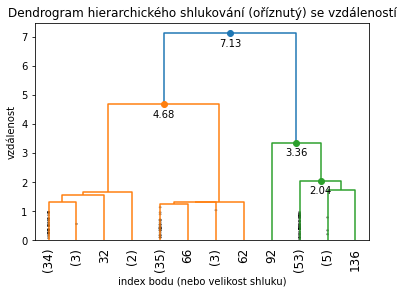

In [15]:
# Opět si vykreslíme dendrogram
Zagg = get_linkage_matrix(agg)
draw_distance_annotated_dendrogram(
    Zagg,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)

plt.show()

### Úkol - experimentujte na tomto datasetu s dalšími nastaveními vzdálenosti bodů a shluků

Zkuste prozkoumat především vliv nastavení vzdáleností shluků. Zajímavý je výsledek pro _complete_.

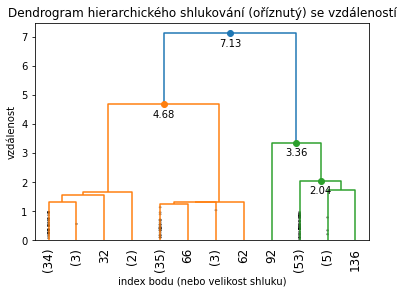

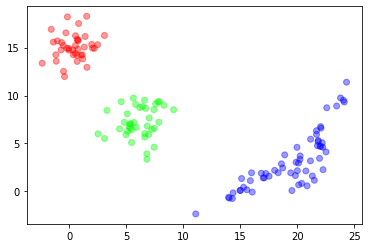

In [16]:
# Váš kód zde

agg = AgglomerativeClustering(distance_threshold=None, n_clusters=3, linkage = 'single', compute_distances = True)
agg.fit(X)
Zagg = get_linkage_matrix(agg)
draw_distance_annotated_dendrogram(
    Zagg,
    truncate_mode="lastp",
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_if_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)

plt.show()

plt.scatter(X[:,0], X[:,1], c=agg.labels_, cmap="brg", alpha=0.4)  # plot points with cluster dependent colors
plt.show()

### Doplnění - evaluaci dendrogramu lze provádět pomocí cophenetické korelace

Jedná se o korelační koeficient mezi vzdálenostmi dvojic bodů $d(x,y)$ a výšky $t(x,y)$ v dendrogramu, kde se poprvé spojují body $x$ a $y$: https://en.wikipedia.org/wiki/Cophenetic_correlation




In [17]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
pdistances = pdist(X, metric = "euclidean")
Z = linkage(X, method="single", metric="euclidean")
cophenet_coef = np.corrcoef(pdistances, cophenet(Z))[0,1]
print(cophenet_coef)

0.8713239094299512


## Algoritmus $k$-means

Použijeme implementaci `sklearn.cluster.KMeans` [(dokumentace zde)](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 3.26207 11.14234]
 [19.44512  3.14041]]


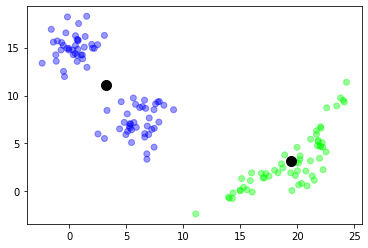

In [18]:
from sklearn.cluster import KMeans

# Nejdřív zkusme 2 shuky
k = 2
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# výsledné shluky
print(kmeans.labels_)
# a jejich středy
print(kmeans.cluster_centers_)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

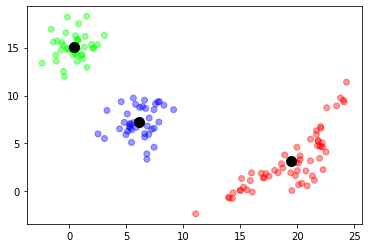

In [19]:
# To stejné pro 3 shluky
k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

V defaultním nastavení probíhá inicializace středů "chytrým" způsobem, `init = 'k-means++'` [David, Vassilvitskii (2007)](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), a běh algoritmu se opakuje 10 krát, `n_init = 10`.

Finálním výstupem je pak výstup nějlepšího běhu (nejmenší hodnota účelové funkce výsledku).

Kromě této "chytré" inicializace je možné použít klasickou náhodnou inicializaci (náhodný výběr z dat) nebo dokonce určit počáteční středy manuálně.

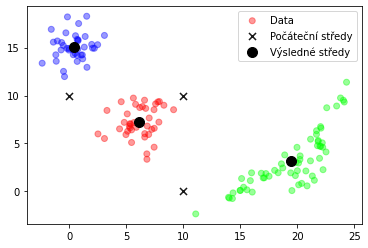

In [20]:
k = 3
# manuální inicializace
initial_centers = np.array([[0,10],[10,10],[10,0]])

# shlukování
kmeans = KMeans(n_clusters = k, random_state = 1, init = initial_centers, n_init = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(initial_centers[:,0], initial_centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # initial centers
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100) # final centers
plt.legend(['Data', 'Počáteční středy', 'Výsledné středy'])
plt.show()

### Určování optimální hodnoty $k$
Zobrazíme hodnotu účelové funkce vzávislosti na $k$ a budeme hledat bod zlomu (loket).

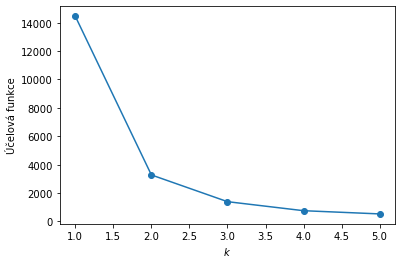

In [21]:
ix = np.zeros(5)
iy = np.zeros(5)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

## Algoritmus DBSCAN

Jako poslední algoritmus si ukážeme algoritmus DBSCAN z poslední přednášky.
Použijeme implementaci `sklearn.cluster.DBSCAN`.


Tento algoritmus automaticky určuje počet shluků a také některé body, které jsou od ostatních shluků "odlehlé", označí jako _šum_ (_noise_). 

Základním hyperparametry algoritmu jsou:
* eps - maximální vzdálenost mezi dvěma body, aby je algoritmus považoval za sousední. Jedná se o nejdůležitější parametr.
* min_samples - minimání počet bodů, které musí být v $\epsilon$-okolí bodu, aby byl bod považován za "core" point.
* metric - metrika


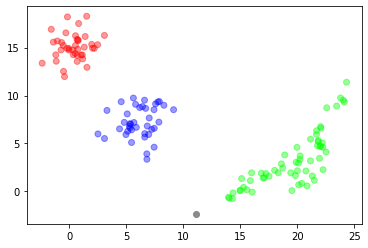

In [22]:
from sklearn.cluster import DBSCAN

# shlukování
clustering = DBSCAN(eps=3).fit(X)

lab = clustering.labels_
# Vizualizace
plt.scatter(X[lab>-1,0], X[lab>-1,1], c=lab[lab>-1], cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(X[lab<-0,0], X[lab<0,1], c='gray',alpha=0.9)  # plot noise
plt.show()

Jako "sum" zde byl označen jeden bod.

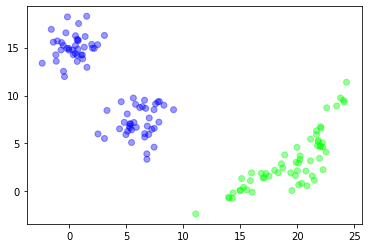

In [23]:
clustering = DBSCAN(eps=5).fit(X)

lab = clustering.labels_
# Vizualizace
plt.scatter(X[lab>-1,0], X[lab>-1,1], c=lab[lab>-1], cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(X[lab<-0,0], X[lab<0,1], c='gray',alpha=0.9)  # plot noise
plt.show()

## Shlukování na Irirs datasetu

Podívejme se nyní na výkonnost shlukovacích algoritmů na známém Iris datasetu.

Pokusíme se prozkoumat, zda shlukování dokáže identifikovat jednotlivé třídy a vůbec poznat, že by mohly být 3.

Vysvětlovanou zde budeme používat pouze k měření výsledků shlukování.

In [24]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

print('X shape:', X.shape)

X shape: (150, 4)


## Úkol - proveďte hierarchické shlukování na Iris datasetu
* Hledejte 3 shluky
* Diskutujte a kvantifikujte vhodným způsobem kvalitu výsledných shluků ve vztahu ke skutečným druhým kosatců (Setosa, Versicolour a Virginica), které jsou uložené vproměnné y.
* Zkuste najít nejlepší metodu měření vzdáleností shluků, aby získané shluky nejvíce odpovídaly skutečným druhům kosatců.

In [25]:
## Váš kód napište sem
from sklearn.metrics import accuracy_score

clusters =AgglomerativeClustering(n_clusters=3, linkage = 'ward').fit(X).labels_

print('Assigned clusters:', clusters)
print('True types:', y)

# Změna číslování pro konzistenci s datasetem 
clusters[clusters == 1] = 3
clusters[clusters == 0] = 1
clusters[clusters == 3] = 0

print('Accuracy:', accuracy_score(clusters, y))

Assigned clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
True types: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Accuracy: 0.8933333333333333


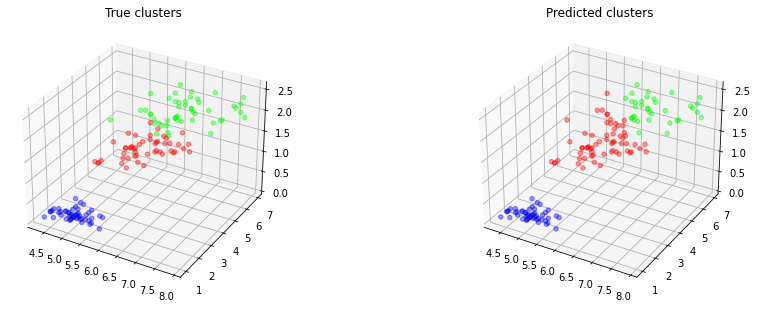

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,2], X[:,3], c=y, cmap='brg', alpha=0.4)
ax.set_title('True clusters')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,0], X[:,2], X[:,3], c=clusters, cmap='brg', alpha=0.4)
ax.set_title('Predicted clusters')

plt.show()

### Úkol - pro porovnání zkuste i KMeans

Assigned clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
True types: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Accuracy: 0.8933333333333333


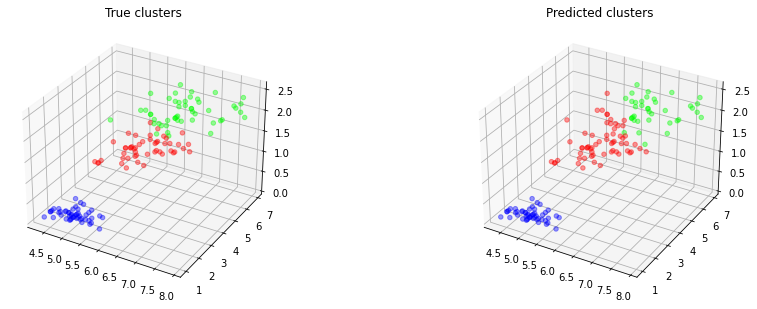

In [27]:
# Váš kód zde

clusters = KMeans(n_clusters = 3, random_state = 1).fit(X).labels_

print('Assigned clusters:', clusters)
print('True types:', y)

# Změna číslování pro konzistenci s datasetem 
clusters[clusters == 1] = 3
clusters[clusters == 0] = 1
clusters[clusters == 3] = 0

print('Accuracy:', accuracy_score(clusters, y))

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,2], X[:,3], c=y, cmap='brg', alpha=0.4)
ax.set_title('True clusters')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,0], X[:,2], X[:,3], c=clusters, cmap='brg', alpha=0.4)
ax.set_title('Predicted clusters')

plt.show()

## Bonus 1 - vektorová kvantizace obrázků

Je třeba instalovat balíček Pillow
`pip install Pillow`. [(dokumentace zde)](https://pypi.org/project/Pillow/)

Nejprve úvodní část kódu, která nás dovede na začátek vlastního problému.

Shape of the array: (341, 512)


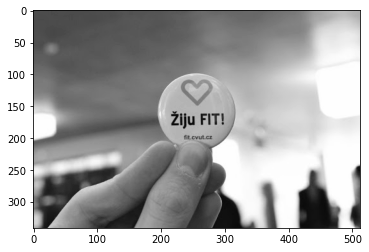

In [28]:
from PIL import Image
# otevření a převedení do stupňů šedi
im = Image.open("img/figure.jpg").convert("L")
# normalizace numpy array na čísla mezi 0 a 1
pix = np.array(im)/255.0
print('Shape of the array:', pix.shape)
# Zobrazení
plt.imshow(pix, cmap="gray", clim=(0, 1));
plt.show()

Vlastní cíl:
* ořízněme obrázek tak, aby jeho šířka byla násobkem 4
* vytvoříme sloupcové bločky délky 4 - tj. části z originálního obrázku s rozměry (1,4).
* provedeme shlukování pomocí k-means s k = 255 shluky - tj. bude stačit jeden bajt na přenesení informace o příslušnosti ke shluku
* extrahujeme středy bloků a labely - tj. indexy příslušnosti originálních bločků k jednotlivým shlukům
* dekódujeme je zpět do pole s rozměrem originálního obrázku - **hint** - využijte: `restored = np.take(centroids, labels, axis = 0)`
* zobrazíme výsledek

(43648, 4)
(16, 4)
(43648,)


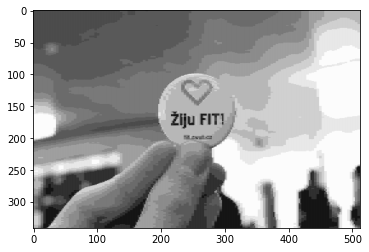

In [29]:
from sklearn.cluster import KMeans

block_len = 4

rows,cols = pix.shape
pix = pix[:, :(cols - cols % block_len)]

X = pix.reshape(-1, block_len)
print(X.shape)

k = 16
kmeans = KMeans(n_clusters=k, random_state=1, n_init=2).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids.shape)
print(labels.shape)

restored = np.take(centroids, labels, axis = 0)
final_pix = restored.reshape(pix.shape)

plt.imshow(final_pix, cmap="gray", clim=(0, 1));
plt.show()

## Bonus 2 - získání "hlavních" barev obrázku

V barevném prostoru provedeme shlukování.

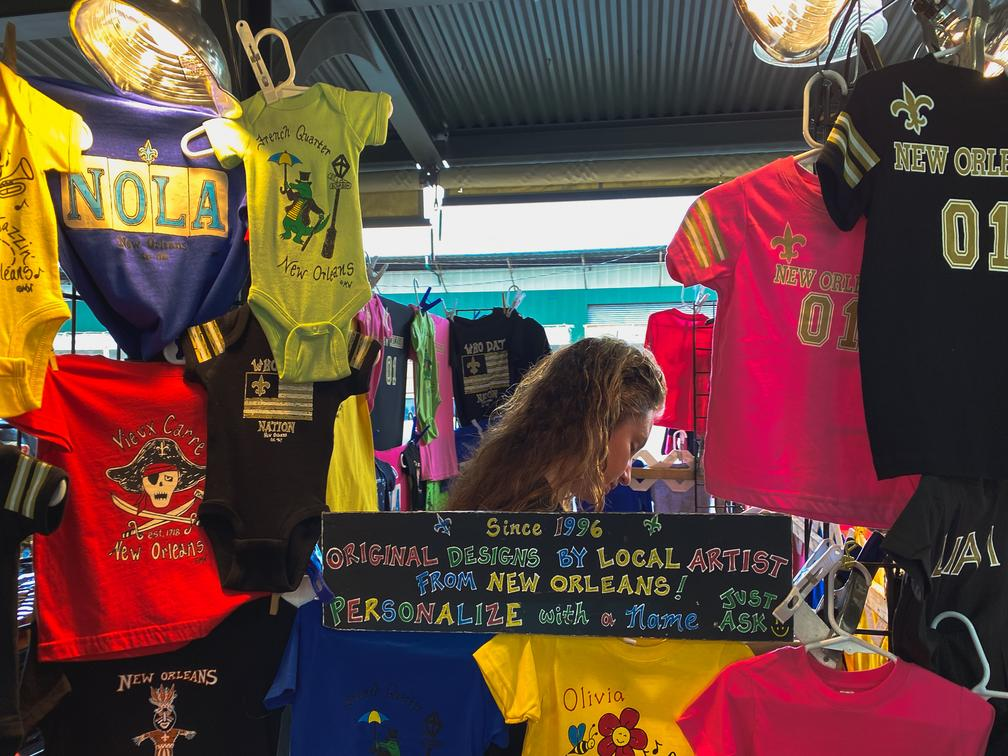

In [30]:
from IPython.display import Image
Image(filename='img/resized.jpg') 

In [31]:
from matplotlib.image import imread
from sklearn.cluster import KMeans
from matplotlib.colors import to_hex
from PIL import Image
import colorsys
import os

palette_size = 10

#load image
img = imread('img/resized.jpg')

#get image dimensions
w, h, d = original_shape = tuple(img.shape)

#set RGB
assert d == 3

#transform to 2D array
image_array = np.reshape(img, (w * h, d))
image_array = image_array/255 #normalizacia
km = KMeans(n_clusters=palette_size, n_init=10, max_iter=300).fit(image_array)

color_list = []

for c in km.cluster_centers_:
    color_list.append(c)

# seřazení pomocí hsv - vypadá pěkně
color_list.sort(key=lambda x: colorsys.rgb_to_hsv(x[0], x[1], x[2]))

boxes = []
for c in color_list:
    print(c)
    boxes.append(Image.new("RGB", (210,210), to_hex(c)))

[0.24434 0.24153 0.24122]
[0.67891 0.6191  0.54929]
[0.39887 0.38776 0.36066]
[0.64531 0.51637 0.11439]
[0.9185  0.73953 0.12147]
[0.89457 0.90626 0.87035]
[0.09842 0.64064 0.68619]
[0.1132  0.11132 0.13974]
[0.57635 0.11609 0.19652]
[0.82374 0.05213 0.17912]


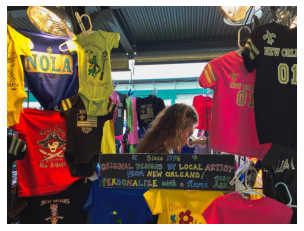

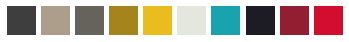

In [32]:
plt.imshow(img)
plt.axis("off")
plt.show()
# display(boxes[1])
fig, ax = plt.subplots(1, palette_size)
for i in range(palette_size):
    ax[i].imshow(np.asarray(boxes[i]))
    ax[i].axis('off')
plt.show()